In [1]:
import numpy as np 
import pandas as pd 
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import bisect
from sklearn.metrics import plot_confusion_matrix

plt.style.use("seaborn")
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# good behavior for notebooks!
sns.set(context='notebook' , color_codes=True)
%matplotlib inline

# Finding Higgs Bosons!!

This notebook will serve as a building block for homework set four, in which you'll be exploring the use of Neural Networks (NNs) to study a represenative data sample from the search for the Higgs boson at the Large Hadron Collider (LHC).  In 2014, a machine learning challenge was posted to Kaggle to encourage data scientists across the world to try their hand(s) at searching for Higgs bosons in a simulated data sample.  The simulations were identical to the ones used by the ATLAS collaboration to search for Higgs bosons decaying to two tau leptons ($H \rightarrow \tau^+ \tau^-$).

Many people tried their best and after 6 months the contest ended.  Three winners were chosen by the contest judges and were awarded cash prizes, as well as an expense-paid trip to CERN:

1.  Gabor Melis : 7000 dollars
2.  Tim Salimans : 4000 dollars
3.  Pierre Courtiol (nhlx5haze) : 2000 dollars

You can find details about the challenge at the primary ATLAS site (https://higgsml.lal.in2p3.fr) and on Kaggle (https://www.kaggle.com/c/higgs-boson/).  The data sample consists of over 800k "events" that are a mixture of simulated $H \rightarrow \tau^+ \tau^-$ signal events with $M_{Higgs}=125$ GeV in addition to a range of non-Higgs "background" events (eg, $Z \rightarrow \tau^+ \tau^-$).  In this context, one event corresponds to a proton-proton collision at the LHC that was recorded by the ATLAS detector.  The signal-to-background ratio is roughly 0.0017, so the challenge is much like searching for a needle in a haystack! 

The data sample consists of 17 "primitive / PRI" features that correspond to the reconstructed observables in each event and 13 "derived / DER" features that are constructed from the primitive features using domain knowledge of the signal and background processes.  In addition, the are unique identifiers (Event ID) and sample weights that allow for converting from integer simulated events to the expected number of events to have been produced in the data sample.  A detailed description of the features is provided here (http://opendata.cern.ch/record/328) and in even more detail here (http://opendata.cern.ch/record/329).  You are not expected to spend time learning the details, so this is for your own interest.

The contestants were given the first 250k events with labels ("s" and "b") to allow for training of a supervised learning classifier.  In addition, a second sample of 250k events **without** labels was provided as a way of testing for overtraining.  A third sample of ~300k events was withheld by the contest organizers as a blind validation sample to rank the contestants.  The ranking was performed by evaluating a metric called the "Approximate Median Significance", wherein a larger value corresponds to a more significant observation of Higgs boson production.  The submissions at the top of the leaderboards had AMS scores around 3.80.

$AMS  = \sqrt{2\left( (s+b+10)\log\left(1+{s \over b+10}\right) -s \right)}$


Your challenge in homework set four will be to engage in the Higgs boson ML contest for yourself as a way to learn about NNs.  We will use this data set for class sessions on Feb 23, Feb 25 and Mar 4.  In this notebook, we will explore the use of the Multilayer Perceptron classifier offered by `scikit-learn`.  In the following class periods, we will explore the use of `PyTorch` and `Keras` as alternative NN frameworks.

# Load the data sample

The first thing to do here is load the data sample.  We will use the `pandas` `dataframe` class, as it's well suited to this task.  For the training sample, we will use the first 350k samples.  The remaining samples will be for validation and evaluation of independent AMS scores.

In [2]:
# read the first 350k samples
dataset=pd.read_csv('higgs-boson/atlas-higgs-challenge-2014-v2.csv',nrows=350000)

# summarize the data

# shape
print("Shape:\n",dataset.shape, "\n")

# first 20 samples
print("Head:\n",dataset.head(20), "\n")

# descriptions
print("Description:\n",dataset.describe(), "\n")

# class distributio
print("Class Distribution:\n",dataset.groupby('Label').size())


Shape:
 (350000, 35) 

Head:
     EventId  DER_mass_MMC  DER_mass_transverse_met_lep  DER_mass_vis  \
0    100000       138.470                       51.655        97.827   
1    100001       160.937                       68.768       103.235   
2    100002      -999.000                      162.172       125.953   
3    100003       143.905                       81.417        80.943   
4    100004       175.864                       16.915       134.805   
5    100005        89.744                       13.550        59.149   
6    100006       148.754                       28.862       107.782   
7    100007       154.916                       10.418        94.714   
8    100008       105.594                       50.559       100.989   
9    100009       128.053                       88.941        69.272   
10   100010      -999.000                       86.240        79.692   
11   100011       114.744                       10.286        75.712   
12   100012       145.297         

# Now groom the data sample

We need prepare a subset of the sample on which to train.  We will remove all of the variables that should not be used in the training and retain the rest.  In addition, we'll keep a copy of the labels and weights for later.

In [3]:
# Make a new dataframe without some of the features
X = dataset.drop([ 'Label','EventId','Weight','KaggleSet','KaggleWeight'],axis=1,inplace=False)
weights = dataset['Weight'].values

# We'll find it useful to have the dataframe column names
colNames = X.columns

# Two forms of the 
y = pd.get_dummies(dataset.Label)
yt = y.values[:,0]

# Build selectors to separate our data in to signal and background
sSelector = np.array(yt == 0)
bSelector = np.array(yt == 1)

# Calculate what's in our samples
sumWeights = np.sum(weights)
sumSWeights = np.sum(weights[sSelector])
sumBWeights = np.sum(weights[bSelector])
print("Total Events: {}, Signal: {}, Background: {}".format(sumWeights,sumSWeights,sumBWeights))

Total Events: 175886.38646959182, Signal: 297.4593763421059, Background: 175588.92709324966


# Make some figures!

Next let's make figures of the different variables in the data sample.  There are 30 features available, of varying levels of discrimination between signal and background classes.

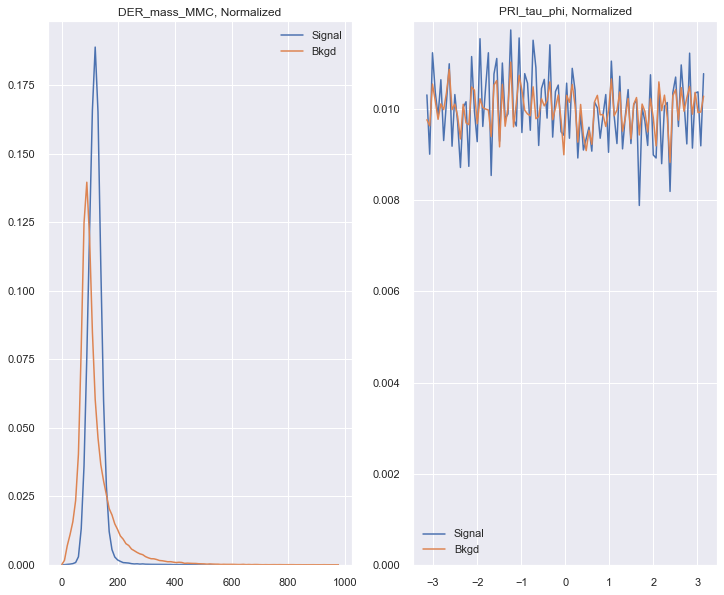

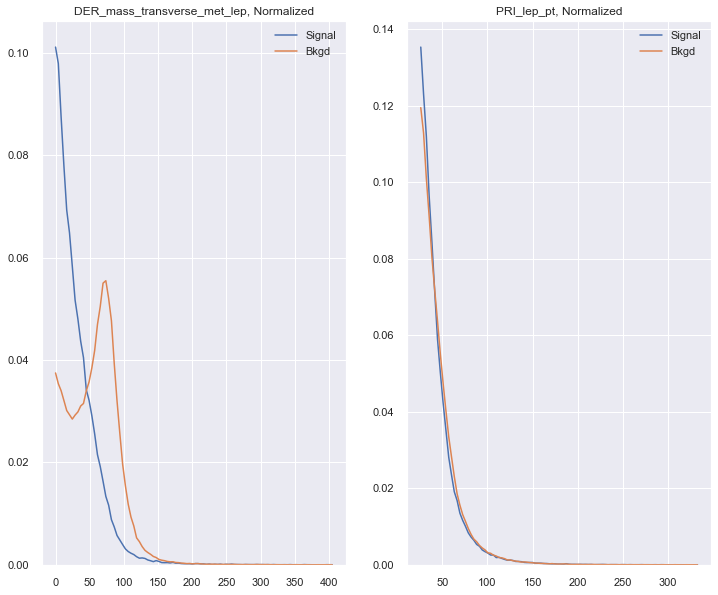

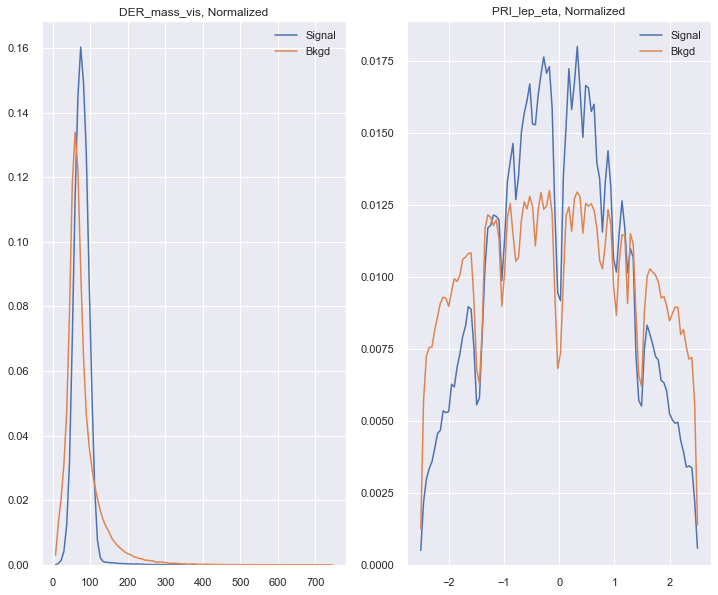

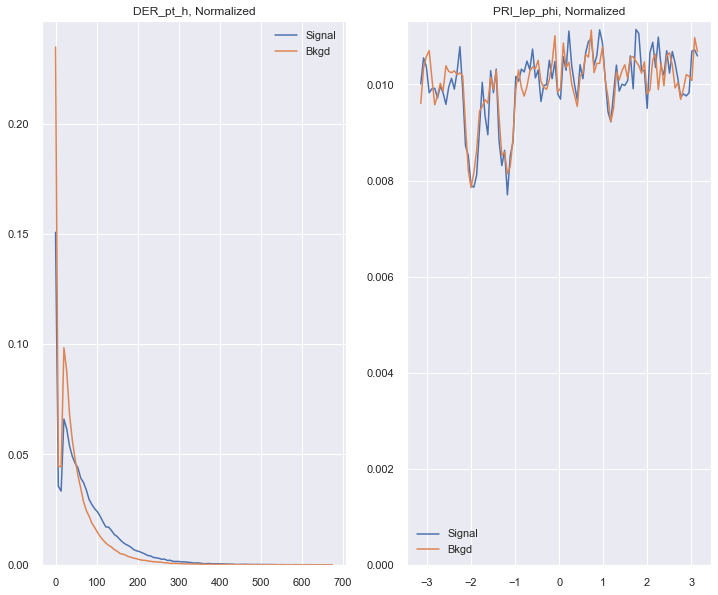

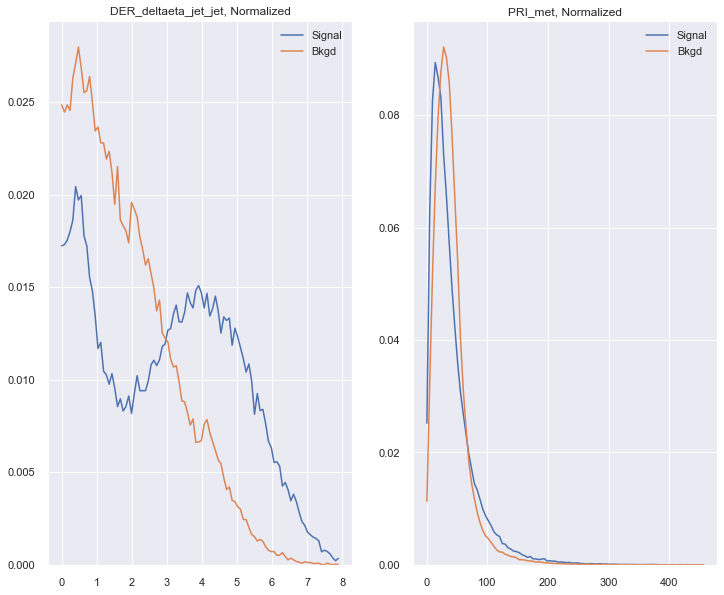

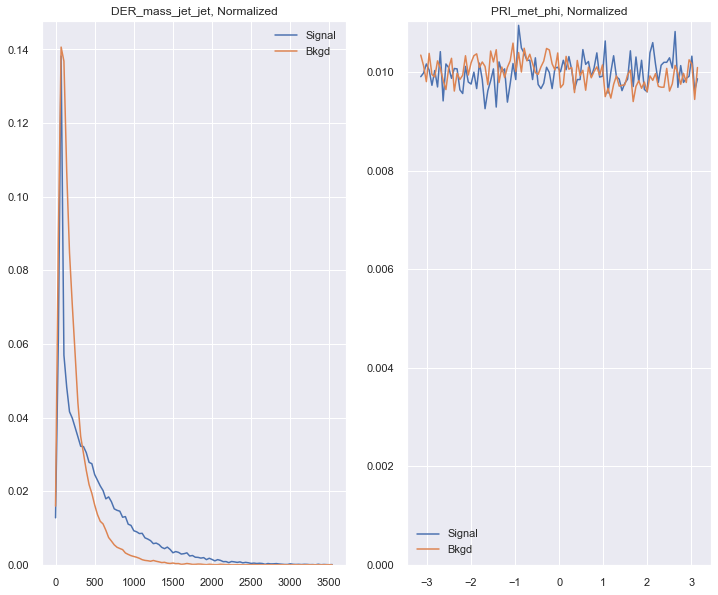

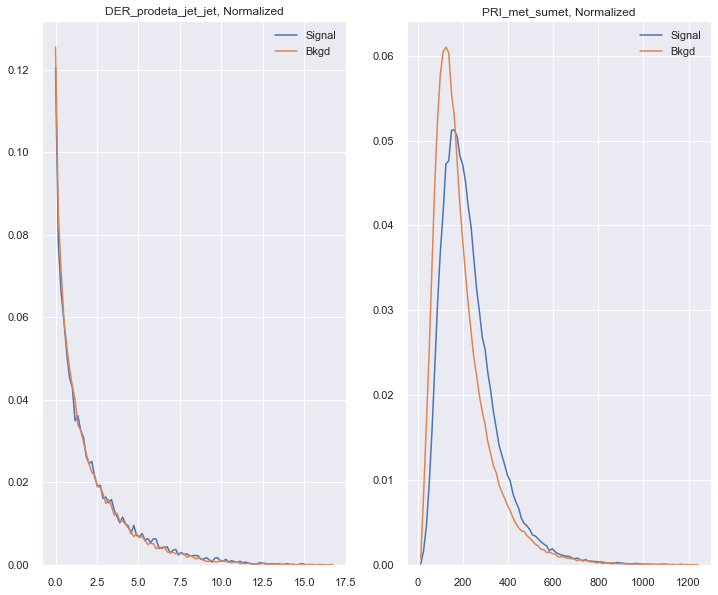

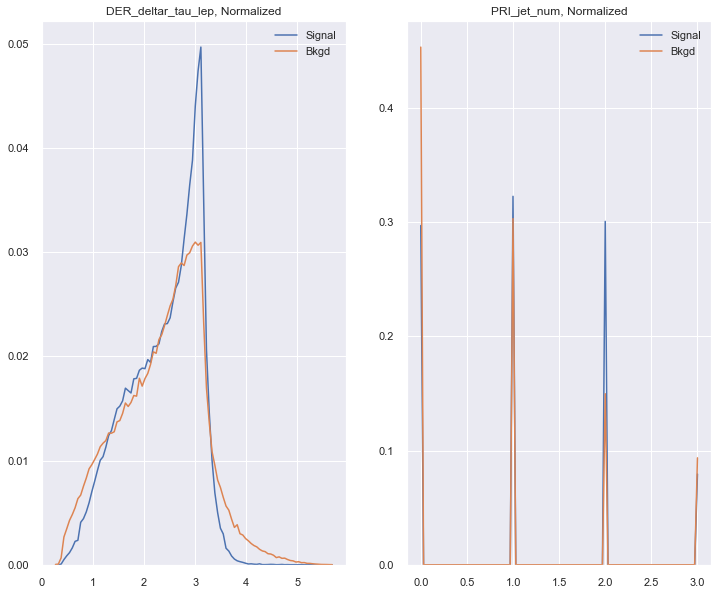

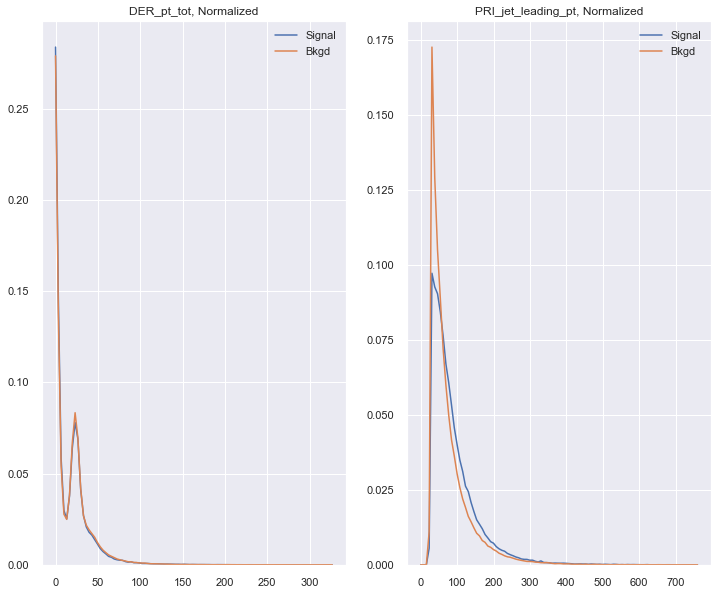

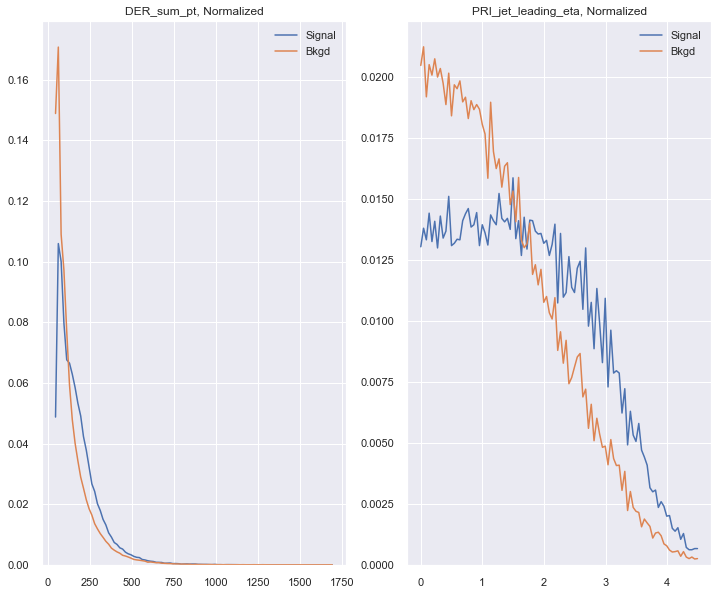

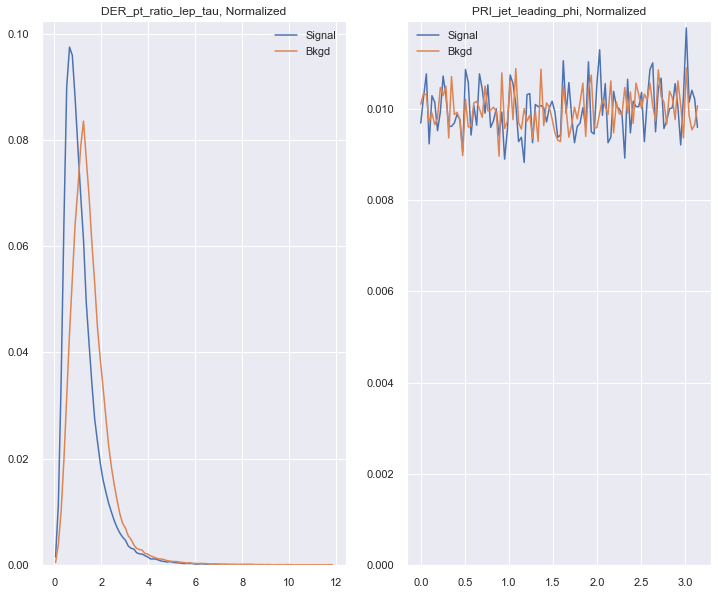

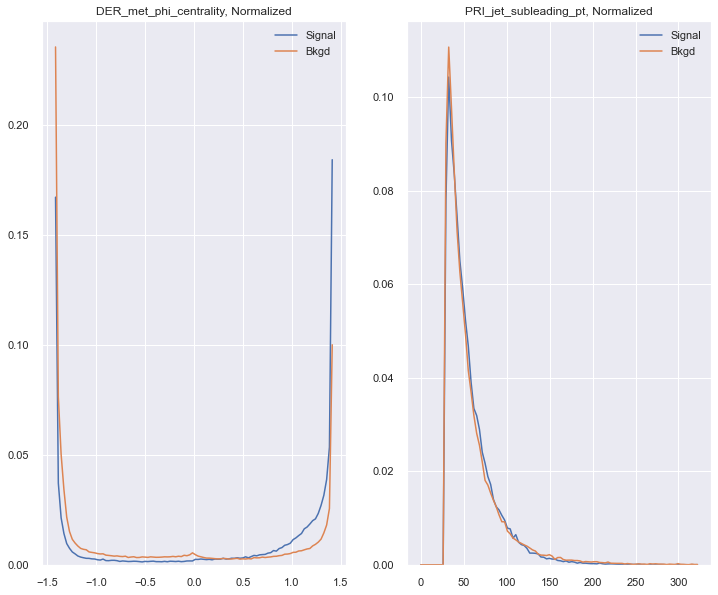

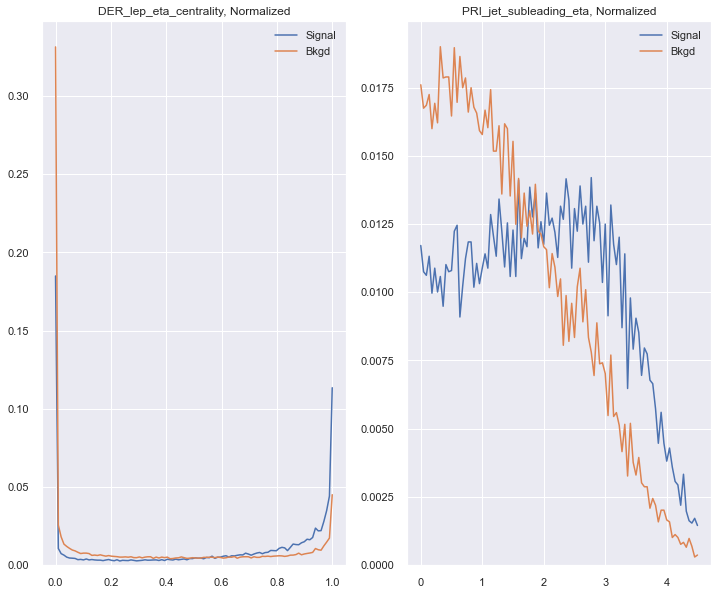

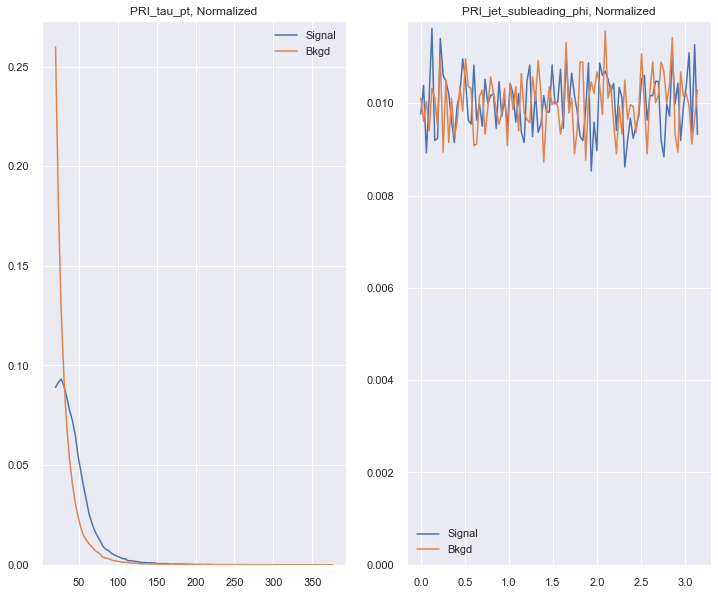

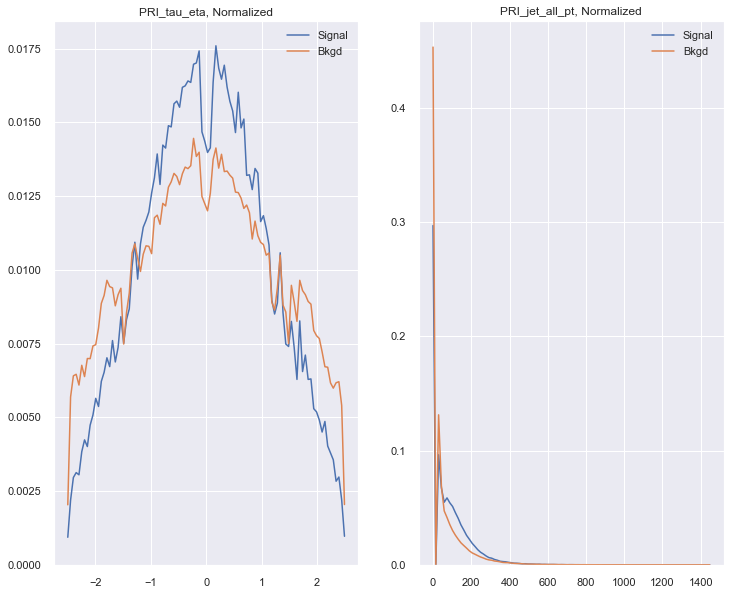

In [4]:
def getRange(sig, bkg):
    ret = np.zeros(2)
    amin = np.min(sig)
    ret[0] = amin
    if amin <-998:
        ret[0] = 0
    vals, bins = np.histogram(sig,bins=100)
    vals2, bins2 = np.histogram(bkg,bins=100)

    ret[1] = np.maximum(np.max(sig),np.max(bkg))

    idx = 0
    for val in vals:
        if val > 2:
            ret[1] = bins[idx+1]
        if vals2[idx] > 2:
            ret[1] = bins2[idx+1]
        idx += 1
        
    if ret[1] < ret[0]:
        ret[1] = np.maximum(np.max(sig),np.max(bkg))
    
    if np.abs(1.0-ret[1])<0.1:
        ret[1] = 1.0
    
    return ret

def plotHisto(sig,bkg,label,ax, doNorm=True, s_weight=None, b_weight=None):
    trange = getRange(sig,bkg)
    
    sweight = None
    bweight = None
    if doNorm == True:
        sweight = s_weight
        bweight = b_weight
    
    sVals, edges = np.histogram(sig,bins=100,range=trange,weights=sweight)
    bVals, edges = np.histogram(bkg,bins=100,range=trange,weights=bweight)
    xvals = np.linspace(trange[0],trange[1],100)
    
    if doNorm:
        ax.plot(xvals,sVals/np.sum(sVals),label="Signal")
        ax.plot(xvals,bVals/np.sum(bVals),label="Bkgd")
        ax.set_title("{}, Normalized".format(label))
    else:
        ax.plot(xvals,sVals,label="Signal")
        ax.plot(xvals,bVals,label="Bkgd")
        ax.set_title("{}, Unnormalized".format(label))
    ax.set_ylim(bottom=0)
    ax.legend()


for idx in range(int(colNames.size / 2)):
    idx2 = int(colNames.size / 2)+idx
    
    fig, axs = plt.subplots(1,2, figsize=(12,10))
    plotHisto(X[colNames[idx]].values[sSelector],X[colNames[idx]].values[bSelector],colNames[idx],axs[0])
    plotHisto(X[colNames[idx2]].values[sSelector],X[colNames[idx2]].values[bSelector],colNames[idx2],axs[1])

    plt.show()

# Build a neural network

Our goal is to correctly classify signal and background events.  There are many ways to approach this, but for now we'll focus on neural networks.  For this exercise, we'll get started by using the Multilayer Perceptron class from `scikit-learn`.  This has become a very nice implementation that can create rather deep networks.  The major downside is that it does not have GPU or TPU support.

For our first step, let's consider that we have 30 features.  This is a relatively large space with many potential correlations, so we'll want to try for a relatively large network.  Let's start off by creating a network with one hidden layers with 10 nodes (neurons).  This will give us a first benchmark for our problem.

In [5]:
clf = MLPClassifier(hidden_layer_sizes=(10,),
                    random_state=1,verbose=True,max_iter=50)

clf.fit(X.values,yt)

Iteration 1, loss = 1.68235756
Iteration 2, loss = 0.60500228
Iteration 3, loss = 0.57931639
Iteration 4, loss = 0.56186698
Iteration 5, loss = 0.55137308
Iteration 6, loss = 0.54624376
Iteration 7, loss = 0.54194161
Iteration 8, loss = 0.53897348
Iteration 9, loss = 0.53112065
Iteration 10, loss = 0.52973898
Iteration 11, loss = 0.51859766
Iteration 12, loss = 0.51314738
Iteration 13, loss = 0.51122636
Iteration 14, loss = 0.50166398
Iteration 15, loss = 0.50663342
Iteration 16, loss = 0.50025967
Iteration 17, loss = 0.49873305
Iteration 18, loss = 0.48988175
Iteration 19, loss = 0.49271535
Iteration 20, loss = 0.49088948
Iteration 21, loss = 0.49163182
Iteration 22, loss = 0.48319240
Iteration 23, loss = 0.48895824
Iteration 24, loss = 0.48410698
Iteration 25, loss = 0.48354182
Iteration 26, loss = 0.48716345
Iteration 27, loss = 0.47586814
Iteration 28, loss = 0.47988350
Iteration 29, loss = 0.47854490
Iteration 30, loss = 0.48423095
Iteration 31, loss = 0.47087816
Iteration 32, los

/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(10,), max_iter=50, random_state=1,
              verbose=True)

In [21]:
def plotNNresults(predictions,sSelector,bSelector,weights):
    fig, axs = plt.subplots(1,2, figsize=(14,6))
    plotHisto(predictions[sSelector,0],predictions[bSelector,0],"Neural Nework",
              axs[0],doNorm=False)
    plotHisto(predictions[sSelector,0],predictions[bSelector,0],"Neural Nework",
              axs[1],doNorm=True,b_weight=weights[bSelector],s_weight=weights[sSelector])
    plt.show()
    
    class_names = ['Signal','Background']
    fig, ax = plt.subplots(1,2,figsize=(14,6))
    plt.rcParams.update({'font.size': 22})
    disp = plot_confusion_matrix(clf, X.values, yt, display_labels=class_names,normalize='true',ax=ax[0])
    ax[0].set_title("Unweighted")
    plt.grid(False)

    disp = plot_confusion_matrix(clf, X.values, yt, display_labels=class_names,normalize='true',ax=ax[1],sample_weight=weights)
    ax[1].set_title("Weighted")
    plt.grid(False)
    plt.show()

# Now let's plot our NN results

We'll first pull the score (overall accuracy) and then plot the NN output values as well as the confusion matrix.  Note that we get somewhat different results for the cases in which we weight our events.

Unweighted score:  0.7891771428571429
Weighted score:  0.8711709383653184
Prediction array structure:
 [[0.59981086 0.40018914]
 [0.71572349 0.28427651]
 [0.01338727 0.98661273]
 [0.12313833 0.87686167]
 [0.21856087 0.78143913]
 [0.34886936 0.65113064]
 [0.91149967 0.08850033]
 [0.95418336 0.04581664]
 [0.14312181 0.85687819]
 [0.62242373 0.37757627]]


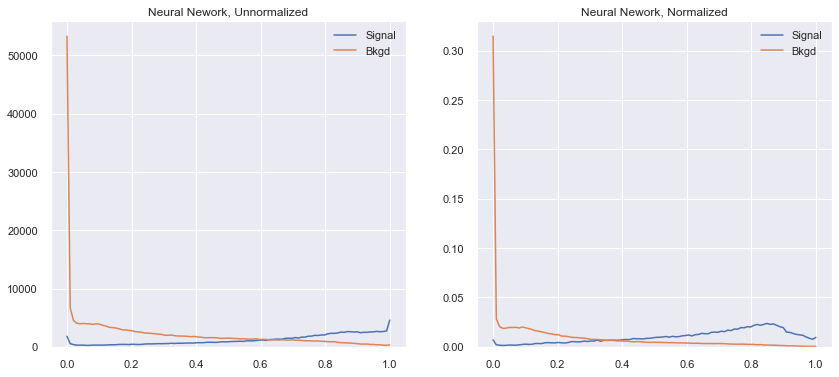

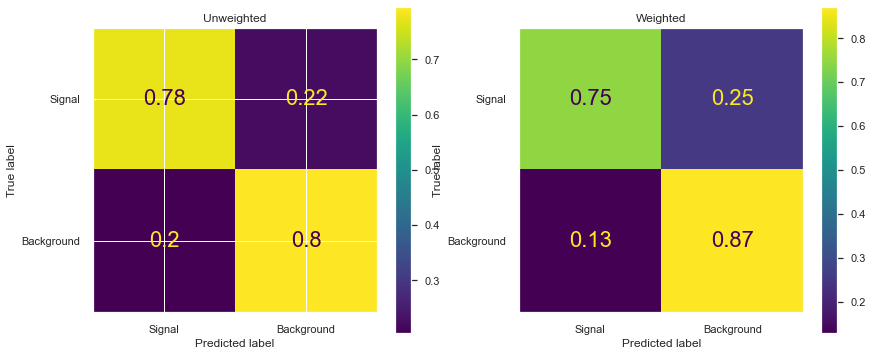

In [22]:
print("Unweighted score: ", clf.score(X.values,yt))
print("Weighted score: ",clf.score(X.values,yt,weights))

predictions = clf.predict_proba(X.values)

print("Prediction array structure:\n",predictions[:10])

plotNNresults(predictions,sSelector,bSelector,weights) 


# Making a confusion plot "by hand"

We won't always want to interface to `scikit-learn` to make confusion plots, so here is an example of how to do so.

Fractions:  0.7494723256371257 0.1286228960521297
[[0.74947233 0.25052767]
 [0.1286229  0.8713771 ]]


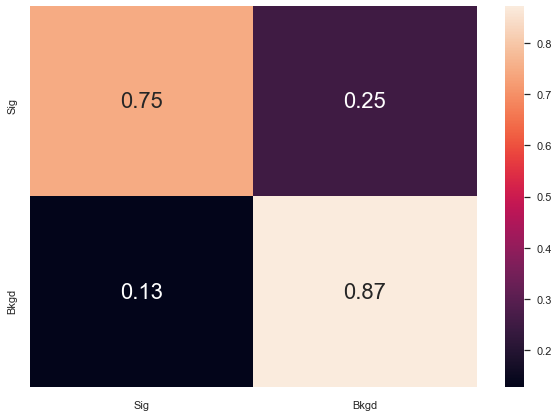

In [8]:
# pick up the predictions for one class
tvals = predictions[:,0]

# order them 
permute = tvals.argsort()
sSelectorP = sSelector[permute]
bSelectorP = bSelector[permute]
tvals = tvals[permute]
weightsP = weights[permute]

# pick out only the signal values
sVals = tvals[sSelectorP]
sigW = weightsP[sSelectorP]

# pick out only the background values
bVals = tvals[bSelectorP]
bkgW = weightsP[bSelectorP]

# find the array index that divides the sample at a NN score of 0.50
idxS = bisect.bisect_left(sVals,0.50)
idxB = bisect.bisect_left(bVals,0.50)

myConfMatrix = np.zeros((2,2))
sFrac = np.sum(sigW[idxS:])/np.sum(sigW)
bFrac = np.sum(bkgW[idxB:])/np.sum(bkgW)
print("Fractions: ",sFrac,bFrac)
myConfMatrix[0,0] = sFrac
myConfMatrix[0,1] = 1-sFrac
myConfMatrix[1,0] = bFrac
myConfMatrix[1,1] = 1-bFrac

print(myConfMatrix)

#This is just an example, but we can use Seaborn to make a heatmap with our confusion matrix
df_cm = pd.DataFrame(myConfMatrix, index = ["Sig","Bkgd"],
                  columns = ["Sig","Bkgd"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.show()

# Finally, let's check to see how we did for our challenge

The challenge was "judged" based on the Approximate Mean Significance (AMS) score.  Let's just quickly check how we did on our training data.  This is an over-estimate because we trained on this data, but it will give us an idea of how we did!  Remember the best work in the Higgs ML challenge achieved an AMS score of ~ 3.80.

In [9]:
def ams(s,b):
    from math import sqrt,log
    if b==0:
        return 0
    
    return sqrt(2*((s+b+10)*log(1+float(s)/(b+10))-s))

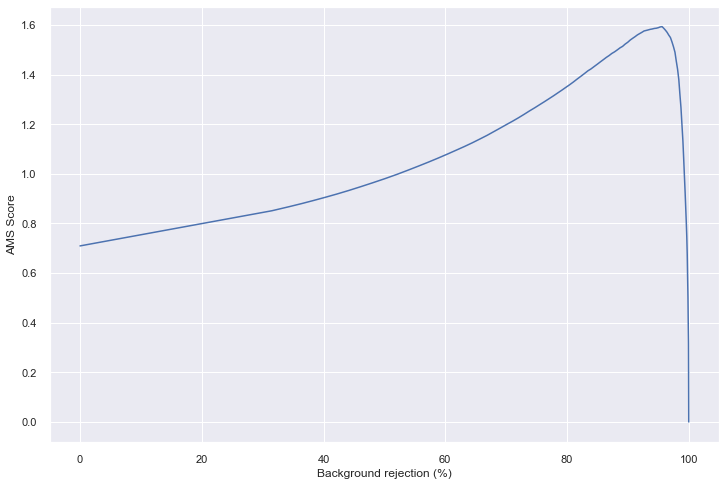

Maximum AMS Value:  1.5934140416356566


In [10]:
xvals = np.linspace(0,1,100)
amsV = np.linspace(0,1,100)
bkgFrac = np.linspace(0,1,100)
aIdx = 0

# We are going to organize by background rejection fraction,
# so we need to 
for xx in xvals:
    idxS = bisect.bisect_left(sVals,xx)
    idxB = bisect.bisect_left(bVals,xx)
    amsV[aIdx] = ams(np.sum(sigW[idxS:]),np.sum(bkgW[idxB:]))
    bkgFrac[aIdx] = 1-np.sum(bkgW[idxB:])/np.sum(bkgW)
    aIdx += 1

permute = bkgFrac.argsort()
bkgFrac = bkgFrac[permute]
amsV = amsV[permute]

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(bkgFrac*100,amsV)
ax.set_xlabel("Background rejection (%)")
ax.set_ylabel("AMS Score")
plt.show()
print("Maximum AMS Value: ",np.max(amsV))